In [1]:
import os
import sys
import re
import time
import random
import warnings
import collections
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

sys.path.append('../src')
import cb_utils

sns.set(style="darkgrid")
pd.options.display.max_columns = 500

%load_ext autoreload
%autoreload 2

# DS Patient Matching Exploration

### EDA

In [48]:
df = pd.read_csv('/Users/bp/workspace/cb/data-analytics/notebooks/data/ds_member_matching20221031.csv')
df.head()

,payer_id,patient_id,analytics_member_id,sfere_id,total_impairment_sum,adl_impairment_sum,transfer_bed_to_chair,transfer_chair_to_standing,mobility,dressing,bathing,eating,grooming,toileting,turn_change_position,calling_friends_and_family,articulating_needs,meal_prep,shopping,medication_management,finances,housework,transportation,driving,daily_routine_decisions,comprehension,member_opinion,cleaning,laundry,change_bed,clean_kitchen,clean_home,medical_appointments,work_school_socialize,best_in_class_assessor,assessor,reporting_current_hrs,reporting_rec_hrs,submitted_at,submitted_last_30d,age
0,2,1,3167,33,29,16,2,2,2,2,2,2,2.0,2,NaN,2,1,2,2,NaN,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Maria Plunkett,30.0,25.0,2020-12-20 15:26:06.000000,False,84
1,2,1,3167,6254,19,14,2,2,2,2,2,0,2.0,2,NaN,1,0,2,0,0.0,0.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Erin Lenahan,15.0,15.0,2021-12-29 20:51:41.070885,False,84
2,2,2,3678,131,29,19,3,3,3,2,3,0,2.0,3,NaN,0,0,2,2,NaN,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Maria Plunkett,48.0,40.0,2021-01-12 23:58:03.877177,False,75
3,2,2,3678,9489,26,22,3,3,3,3,3,1,3.0,3,NaN,0,1,1,0,1.0,0.0,1.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Katy Slaven,48.0,48.0,2022-01-27 18:56:10.709471,False,75
4,2,4,3653,5642,19,14,2,2,2,2,2,0,2.0,2,NaN,0,0,1,1,1.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Maria Plunkett,49.0,40.0,2021-04-22 23:56:28.074340,False,52


In [49]:
df.best_in_class_assessor.value_counts()

False    12871
True      1430
Name: best_in_class_assessor, dtype: int64

In [50]:
melted = pd.melt(df, id_vars=['best_in_class_assessor'], value_vars=['reporting_current_hrs', 'reporting_rec_hrs'])

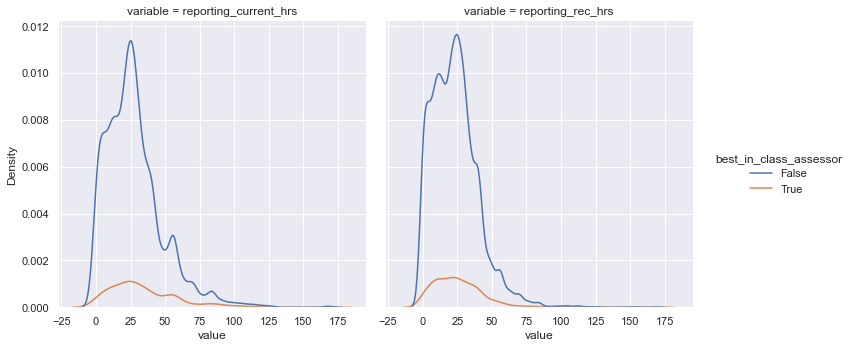

In [51]:
# histogram of total_impairment aka sum(iadl+adl)
sns.displot(data=melted, x="value", hue='best_in_class_assessor', kind='kde', col='variable')

In [52]:
melted = pd.melt(df, id_vars=['best_in_class_assessor', 'total_impairment_sum'], value_vars=['reporting_current_hrs', 'reporting_rec_hrs'])

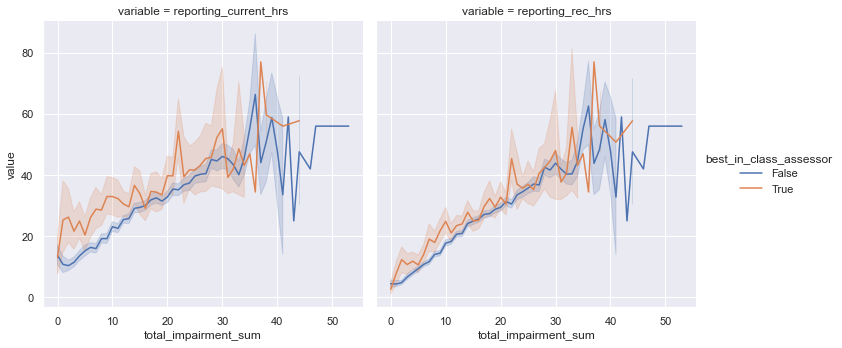

In [53]:
sns.relplot(data=melted, x='total_impairment_sum', y='value', kind='line', hue='best_in_class_assessor', col='variable')

In [54]:
melted = pd.melt(df, id_vars=['best_in_class_assessor', 'adl_impairment_sum'], value_vars=['reporting_current_hrs', 'reporting_rec_hrs'])

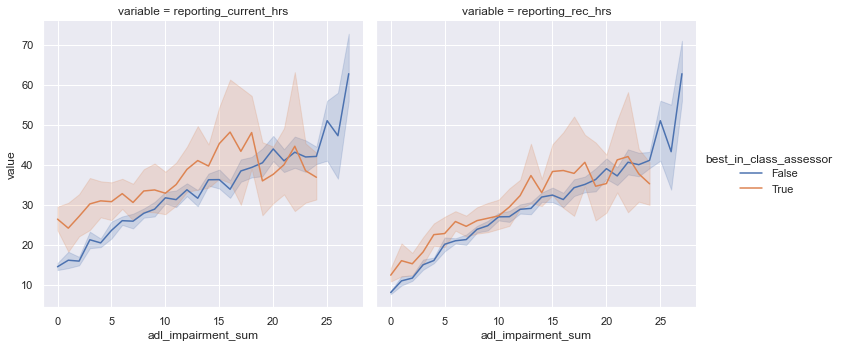

In [55]:
sns.relplot(data=melted, x='adl_impairment_sum', y='value', kind='line', hue='best_in_class_assessor', col='variable')

In [56]:
bic = df.loc[df.best_in_class_assessor]
normie = df.loc[~df.best_in_class_assessor]

In [57]:
(bic.reporting_current_hrs - bic.reporting_rec_hrs).describe()

count    1390.000000
mean        8.084906
std        14.583969
min       -35.000000
25%         0.000000
50%         2.000000
75%         9.000000
max       111.000000
dtype: float64

In [58]:
(normie.reporting_current_hrs - normie.reporting_rec_hrs).describe()

count    10976.000000
mean         4.728499
std         11.165226
min        -24.500000
25%          0.000000
50%          0.000000
75%          4.000000
max        117.000000
dtype: float64

### Modeling

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor

In [60]:
features = [
    'payer_id',
    'age',
    # 'reporting_current_hrs',
    # adls
    'transfer_bed_to_chair',
    'transfer_chair_to_standing',
    'mobility',
    'dressing',
    'bathing',
    'eating',
    'grooming',
    'toileting',
    'turn_change_position',
    # idls
    'calling_friends_and_family',
    'articulating_needs',
    'meal_prep',
    'shopping',
    'medication_management',
    'finances',
    'housework',
    'transportation',
    'driving',
    'daily_routine_decisions',
    'comprehension',
    'member_opinion',
    'cleaning',
    'laundry',
    'change_bed',
    'clean_kitchen',
    'clean_home',
    'medical_appointments',
    'work_school_socialize'
]
target = 'reporting_rec_hrs'

In [61]:
len(features)

30

### Best in class assessor model

In [62]:
# drop na targets from training set
training_df = df.loc[~df[target].isna()]

test_df = training_df.loc[~training_df.submitted_last_30d.isna()]
test_df = test_df.loc[test_df.submitted_last_30d]

training_df = training_df.loc[training_df.best_in_class_assessor]

training_df = training_df.loc[~training_df.sfere_id.isin(test_df.sfere_id)]

# training_df = training_df.loc[training_df[target] > 0]
# training_df = training_df.loc[training_df[target] <= 40]

X_train = training_df[features]
y_train = training_df[target]

X_test = test_df[features]
y_test = test_df[target]
X_train.shape, X_test.shape

((1203, 30), (1153, 30))

In [63]:
est = HistGradientBoostingRegressor(categorical_features=[0]).fit(X_train, y_train)
preds = est.predict(X_test)

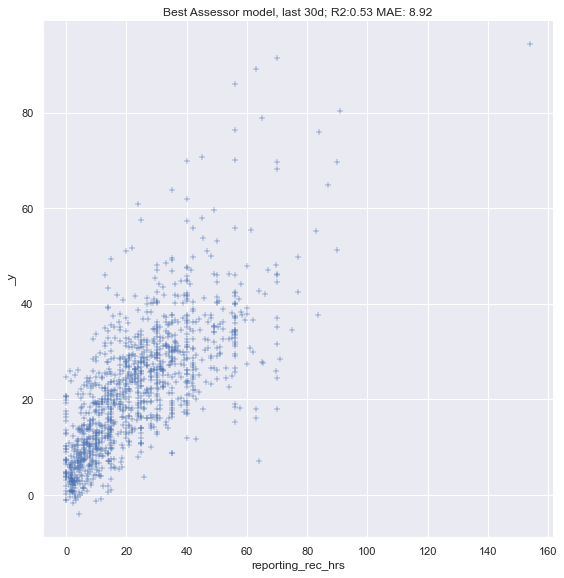

In [64]:
# preds vs rec
ax = sns.relplot(x=y_test, y=preds, marker='+', height=8)
ax.set(title=f'Best Assessor model, last 30d; R2:{est.score(X_test, y_test):.02f} MAE: {np.mean(np.abs(y_test - preds)):.02f}')

### All assessor model

In [65]:
# drop na targets from training set
training_df = df.loc[~df[target].isna()]

test_df = training_df.loc[~training_df.submitted_last_30d.isna()]
test_df = test_df.loc[test_df.submitted_last_30d]

training_df = training_df.loc[~training_df.sfere_id.isin(test_df.sfere_id)]

# training_df = training_df.loc[training_df[target] > 0]
# training_df = training_df.loc[training_df[target] <= 40]

X_train = training_df[features]
y_train = training_df[target]

X_test = test_df[features]
y_test = test_df[target]
X_train.shape, X_test.shape

((11572, 30), (1153, 30))

In [66]:
est = HistGradientBoostingRegressor(categorical_features=[0]).fit(X_train, y_train)
preds = est.predict(X_test)

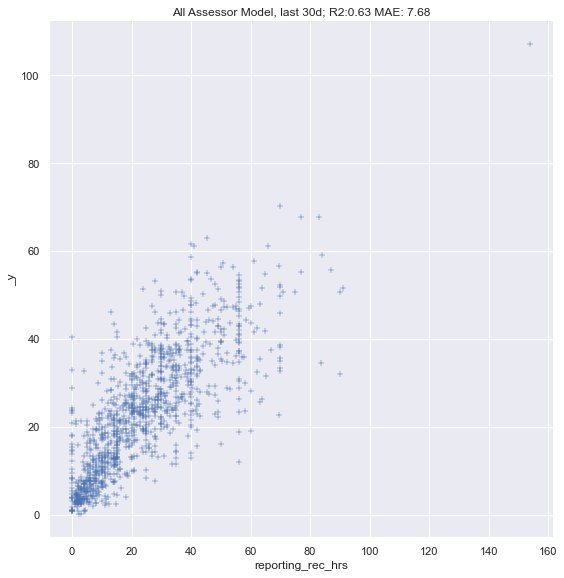

In [78]:
# preds vs rec
ax = sns.relplot(x=y_test, y=preds, marker='+', height=8)
ax.set(title=f'All Assessor Model, last 30d; R2:{est.score(X_test, y_test):.02f} MAE: {np.mean(np.abs(y_test - preds)):.02f}')

In [72]:
tdf = test_df.assign(predicted_hours=preds, rec_minus_pred=test_df.reporting_rec_hrs - preds)
# ax = sns.relplot(data=tdf, x='reporting_rec_hrs', y='predicted_hours', marker='+', height=8)

In [75]:
tdf.rec_minus_pred.describe()

count    1153.000000
mean        0.574304
std        10.918047
min       -40.441815
25%        -5.221063
50%        -0.600407
75%         5.061807
max        57.862358
Name: rec_minus_pred, dtype: float64

In [76]:
tdf.to_csv('./data/recomended_hours_model.csv', index=False)

In [79]:
ax.savefig('/Users/bp/Downloads/recomended_hours_model.png')

In [80]:
training_df.to_csv('./data/recomended_hours_model_training_data.csv', index=False)

In [81]:
tdf.predicted_hours.describe()

count    1153.000000
mean       23.213363
std        13.993476
min         0.256552
25%        11.855752
50%        22.751215
75%        32.738281
max       107.016323
Name: predicted_hours, dtype: float64

In [87]:
tdf.groupby('payer_id').rec_minus_pred.std()

payer_id
2     13.418836
4      8.651885
5      7.775589
6      9.331099
8      4.553883
9     15.814961
12    12.179777
Name: rec_minus_pred, dtype: float64

<AxesSubplot:xlabel='rec_minus_pred', ylabel='Count'>

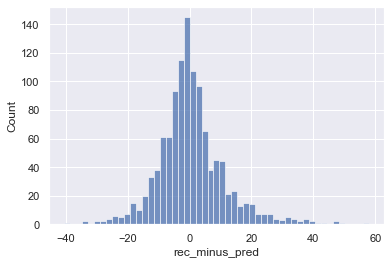

In [83]:
sns.histplot(x=tdf.rec_minus_pred)

<AxesSubplot:xlabel='predicted_hours', ylabel='Count'>

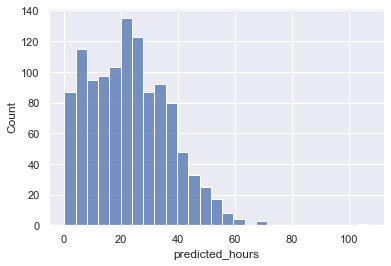

In [84]:
sns.histplot(x=tdf.predicted_hours)

### Feature Importance

In [91]:
from sklearn.inspection import permutation_importance

r = permutation_importance(est, X_test, y_test,
                           n_repeats=30,
                           random_state=0)

In [90]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{features[i]:<8} "
              f"{r.importances_mean[i]:.3f} "
              f" +/- {r.importances_std[i]:.3f}")

payer_id 0.565  +/- 0.035
toileting 0.052  +/- 0.006
housework 0.024  +/- 0.003
meal_prep 0.024  +/- 0.006
eating   0.016  +/- 0.004
transportation 0.013  +/- 0.004
dressing 0.012  +/- 0.003
bathing  0.011  +/- 0.004
medication_management 0.008  +/- 0.003
transfer_bed_to_chair 0.006  +/- 0.003
cleaning 0.002  +/- 0.001
turn_change_position 0.001  +/- 0.000
work_school_socialize 0.000  +/- 0.000


### Tuning

In [116]:
parameters = {
    'max_iter': [1000],
    'max_depth': [3,5,20,25],
    'min_samples_leaf': [10, 20, 50, 75, 100],
    'l2_regularization': [0, .1, .5]
}
parameters

{'max_iter': [1000],
 'max_depth': [3, 5, 20, 25],
 'min_samples_leaf': [10, 20, 50, 75, 100],
 'l2_regularization': [0, 0.1, 0.5]}

In [117]:
est = HistGradientBoostingRegressor(categorical_features=[0])

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

clf = HalvingGridSearchCV(est, parameters, factor=2, n_jobs=-1, verbose=1)
clf.fit(X_train, y_train)

clf.best_score_, clf.best_params_

n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 6
min_resources_: 361
max_resources_: 11572
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 60
n_resources: 361
Fitting 5 folds for each of 60 candidates, totalling 300 fits
----------
iter: 1
n_candidates: 30
n_resources: 722
Fitting 5 folds for each of 30 candidates, totalling 150 fits
----------
iter: 2
n_candidates: 15
n_resources: 1444
Fitting 5 folds for each of 15 candidates, totalling 75 fits
----------
iter: 3
n_candidates: 8
n_resources: 2888
Fitting 5 folds for each of 8 candidates, totalling 40 fits
----------
iter: 4
n_candidates: 4
n_resources: 5776
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 5
n_candidates: 2
n_resources: 11552
Fitting 5 folds for each of 2 candidates, totalling 10 fits


(0.5400063860232673,
 {'l2_regularization': 0.1,
  'max_depth': 3,
  'max_iter': 1000,
  'min_samples_leaf': 100})